# Parallelizing Multiple Grid Cells on a High-Performance Computing Cluster

Building off the previous tutorial, this notebook demonstrates how to use the [Dask PBSCluster](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.PBSCluster.html) object to parallelize MUSICA simulations across HPC systems. While MUSICA is locally efficient for simulations up to around 10,000 grid cells, scaling to larger domains can benefit from parallelizing grid cell calculations to improve runtime performance. This tutorial walks through best practices for setting up and running parallel MUSICA workflows, with concrete examples and reference scaling tests performed on [NCAR’s Casper HPC system](https://ncar-hpc-docs.readthedocs.io/en/latest/compute-systems/casper/).

## 1. Importing Libraries

In addition to libraries previously used throughout MUSICA tutorials, this tutorial uses Dask. Note that if you'd like to visualize Dask graphs, you will also need [Graphviz](https://graphviz.org) installed.

In [ ]:
#import libraries
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dask import delayed, compute
from dask.distributed import Client
from dask_jobqueue import PBSCluster
import numpy as np
import time
from scipy.stats import qmc
import seaborn as sns

## 2. Dask Cluster Set up

We first need to set up a Dask Cluster object. In this tutorial, we use the PBSCluster class since our HPC system uses a PBS-based scheduler, but Dask also provides an equivalent [SLURMCluster](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html) class for SLURM-based systems. When initializing the cluster, you’ll notice it accepts many arguments that may look familiar from your system’s job scripts such as requested memory, number of cores, and walltime. Keep in mind that these values should be adapted to fit your particular workload and system constraints. As a general guideline, we find MultiGrid cell simulations under ~10,000 cells to run comfortably with about 8 GB of memory, while larger simulations ranging from 100,000 to 1,000,000 grid cells may need closer to 15 GB to run efficiently. It can be helpful to initialize the PBSCluster with extra memory as done below (10 GB).

In [ ]:
#casper
cluster = PBSCluster(
    job_name = 'dask-test',
    cores = 1,
    memory = '10GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=10GB', #memory and resource especially memory should match
    queue = 'casper',
    walltime = '50:00',
    interface = 'ext'
)

Prior to running your simulation, it can be helfpul to check the active Dask PBS configuration and resulting job scrip that will be used for your Dask workers.

In [ ]:
#view configuration file(s) within Python
from dask import config
config.refresh()
config.get('jobqueue.pbs')

{'name': 'dask-worker',
 'cores': None,
 'memory': None,
 'processes': None,
 'python': None,
 'interface': None,
 'death-timeout': 60,
 'local-directory': None,
 'shared-temp-directory': None,
 'extra': None,
 'worker-command': 'distributed.cli.dask_worker',
 'worker-extra-args': [],
 'shebang': '#!/usr/bin/env bash',
 'queue': None,
 'account': None,
 'walltime': '00:30:00',
 'env-extra': None,
 'job-script-prologue': [],
 'resource-spec': None,
 'job-extra': None,
 'job-extra-directives': [],
 'job-directives-skip': [],
 'log-directory': None,
 'scheduler-options': {}}

In [4]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-test
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:mem=10GB
#PBS -l walltime=50:00

/glade/work/apak/conda-envs/musicbox/bin/python -m distributed.cli.dask_worker tcp://128.117.208.119:36453 --name dummy-name --nthreads 1 --memory-limit 10.00GiB --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



As in the [previous tutorial](4.%20local_parallelization.ipynb), the Dask Cluster provides a convenient and interactive dashboard to visualize your parallelization work.

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apak/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apak/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.119:36453,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apak/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


After your cluster is created, it needs to be scaled to a certain number of Dask workers. For this tutorial, we have used between 1-4 workers and the results of their performance are included below in section 7. Note that due to the nature of the MUSICA code not releasing Python's Global Interpreter Lock, it was not found to be particularly helpful for performance to increase threads.

In [ ]:
cluster.scale(2)
client.wait_for_workers(2) # wait to launch jobs until all workers needed are available

In [8]:
# See the workers from the cluster object
cluster.workers

{'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}

In [9]:
# See the workers in the job scheduler
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
5630216.casper* apak     jhublog* cr-login-*  72033   1   1    4gb 720:0 R 00:01
5630218.casper* apak     htc      dask-test  103102   1   1   10gb 00:50 R 00:00
5630219.casper* apak     htc      dask-test  103114   1   1   10gb 00:50 R 00:00


## 3. Setting up Grid Cells

We find parallelization for MUSICA simulations to increase performance on system sizes beyond ~10,000 grid cells. However, to keep simulation sizes sand batching reasonable, we use a 10,000 grid cell simulation here as an example. As in the local parallelization notebook, we first define the number of grid cells and set their initial conditions before initializing MUSICA chemistry objects.

In [87]:
num_grid_cells = 10000

In [28]:
ndim = 5
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 10, 10, 10] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

In [86]:
temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

concentrations_solved = []
time_step_length = 1
sim_length = 60
curr_time = 0

## 4. Creating a Delayed Function for Dask

The following delayed function is the same as the one created for the previous [Local Parallelization Tutorial](4.%20local_parallelization.ipynb). However, here it is used to solve one grid cell at a time on an HPC system. Due to the low computational cost of solving single grid cells in MUSICA, this method is not recommended and is only used for scaling comparisons.

In [ ]:
@delayed
def solve_one_cell(cell_index,temperatures,pressures,concentrations, sim_length, time_step):

    # Define the system

    A = mc.Species(name="A") # Create each of the species with their respective names
    B = mc.Species(name="B")
    C = mc.Species(name="C")
    species = [A, B, C] # Bundle the species into a list
    gas = mc.Phase(name="gas", species=species) # Create a gas phase object containing the species

    r1 = mc.Arrhenius( # Create the reactions with their name, constants, reactants, products, and phase
        name="A_to_B",
        A=4.0e-3,  # Pre-exponential factor
        C=50,      # Activation energy (units assumed to be K)
        reactants=[A],
        products=[B],
        gas_phase=gas
    )

    r2 = mc.Arrhenius(
        name="B_to_C",
        A=4.0e-3,
        C=50,  
        reactants=[B],
        products=[C],
        gas_phase=gas
    )

    mechanism = mc.Mechanism( # Define the mechanism which contains a name, the species, the phases, and reactions
        name="musica_micm_example",
        species=species,
        phases=[gas],
        reactions=[r1, r2]
)


    #create the solver
    solver = musica.MICM(mechanism=mechanism, solver_type=musica.SolverType.rosenbrock_standard_order)

    #create the state
    state = solver.create_state(1)
    state.set_conditions(temperatures[cell_index],pressures[cell_index])
    cur_concentrations = {key: value[cell_index] for key, value in concentrations.items()}
    state.set_concentrations(cur_concentrations)

    time = 0.0
    result = []
    track_time = []
    while time <= sim_length:
        solver.solve(state, time)
        result.append(state.get_concentrations().copy())
        track_time.append(time)
        time += time_step

    return {
        "times": np.array(track_time),
        "concentrations": np.stack(result)
    }


In [ ]:
start = time.time()
tasks = [solve_one_cell(i, temperatures,pressures,concentrations, sim_length, time_step_length) for i in range(num_grid_cells)]
results = compute(*tasks)
elapsed = time.time() - start
print(f"parallel 10000 cell finished in {elapsed:.2f} seconds")

parallel 10000 cell finished in 60.77 seconds


## 5. Dask With Batching

Since MUSICA already computes individual grid cells efficiently, the main performance gain from Dask comes from batching—grouping multiple grid cells together so each CPU core processes several cells at once. This allows us to fully use multiple cores while reducing overhead and improving throughput on large simulations.

In [ ]:
@delayed
def solve_batch(start_idx, end_idx, temperatures, pressures, concentrations, sim_length, time_step):
    batch_size = end_idx - start_idx

    # define the system
    A = mc.Species(name="A")
    B = mc.Species(name="B")
    C = mc.Species(name="C")
    species = [A, B, C]
    gas = mc.Phase(name="gas", species=species)

    r1 = mc.Arrhenius(name="A_to_B", A=4.0e-3, C=50, reactants=[A], products=[B], gas_phase=gas)
    r2 = mc.Arrhenius(name="B_to_C", A=4.0e-3, C=50, reactants=[B], products=[C], gas_phase=gas)

    mechanism = mc.Mechanism(
        name="musica_micm_example",
        species=species,
        phases=[gas],
        reactions=[r1, r2]
    )

    # create state for all cells in this batch
    solver = musica.MICM(mechanism=mechanism, solver_type=musica.SolverType.rosenbrock_standard_order)
    state = solver.create_state(batch_size)

    # set conditions and concentrations
    batch_temps = temperatures[start_idx:end_idx]
    batch_pressures = pressures[start_idx:end_idx]
    batch_air_densities = []

    state.set_conditions(batch_temps, batch_pressures)
    air_density = state.get_conditions()['air_density'] # track for later visualization
    batch_air_densities.append(air_density)

    # set concentrations: need shape (batch_size,) for each species
    for species_name, all_values in concentrations.items():
        # slice this batch
        state.set_concentrations({species_name: all_values[start_idx:end_idx]})

    # time stepping
    time = 0.0
    batch_results = []

    while time <= sim_length:
        solver.solve(state, time)
        # get concentrations for all cells at this timestep
        concs = state.get_concentrations().copy() 
        batch_results.append(concs)
        time += time_step

    return np.stack(batch_results), np.array(batch_air_densities)

In [ ]:
batch_size = 100 #number of grid cells solved on a single worker

tasks = []
for start_idx in range(0, num_grid_cells, batch_size):
    end_idx = min(start_idx + batch_size, num_grid_cells)
    task = solve_batch(
        start_idx, end_idx,
        temperatures, pressures, concentrations,
        sim_length, time_step_length
    )
    tasks.append(task)

Upon solving this multiple grid cell calculation in batches, we see that it is much more efficient than it's individually run counter part in section 4.

In [ ]:
start = time.time()
results_and_densities = compute(*tasks)
elapsed = time.time() - start
print(f"parallel 100000 cell batched finished in {elapsed:.2f} seconds")

parallel 10000 cell batched finished in 0.67 seconds


## 6. Visualizing Results

Similar to the [Latin Hypercube Sampling Tutorial](2.%20hypercube.ipynb), the following code prepares the results of the parallelized simulations into a dataframe that gives each time step of each grid cell its own row. The formatting is slightly different due to the Dask calculation returning arrays rather than lists and dictionaries directly but the overall organization is the same.

In [ ]:
#split results and air densities back into their own arrays

species_names = ['A', 'B', 'C']
num_time_steps = sim_length // time_step_length + 1

all_results = []
all_air_densities = []

for batch_result, air_densities in results_and_densities:
    all_results.append(batch_result)        # shape: (batch_size, num_timesteps, num_species)
    all_air_densities.append(air_densities) # shape: (batch_size,)

# Concatenate over grid cells
all_results = np.concatenate(all_results, axis=0)           # shape: (num_grid_cells, num_timesteps, num_species)
all_air_densities = np.concatenate(all_air_densities, axis=0) # shape: (num_grid_cells,)

In [ ]:
concentrations_expanded = []
time = []

for t in range(num_time_steps):
    current_time = t * time_step_length
    for g in range(num_grid_cells):

        # all_results[g][t] is dict with species concentrations

        # Extract the float value from each species list
        concentrations_expanded.append({cur_time: v[0] if isinstance(v, (list, np.ndarray)) and len(v) == 1 else v for k, v in all_results[g][t].items()})

        time.append(current_time)

df_expanded = pd.DataFrame(concentrations_expanded)
df_expanded = df_expanded.rename(columns={
    'A': 'CONC.A.mol m-3', 
    'B': 'CONC.B.mol m-3', 
    'C': 'CONC.C.mol m-3'
})
df_expanded['time.s'] = time

# Add environment columns same as before:
num_rows = num_time_steps * num_grid_cells
df_expanded['ENV.temperature.K'] = np.repeat(temperatures[0], num_rows)
df_expanded['ENV.pressure.Pa'] = np.repeat(pressures[0], num_rows)
df_expanded['ENV.air number density.mol m-3'] = np.repeat(all_air_densities[0], num_rows)

df_expanded = df_expanded[[
    'time.s', 
    'ENV.temperature.K', 
    'ENV.pressure.Pa', 
    'ENV.air number density.mol m-3', 
    'CONC.A.mol m-3', 
    'CONC.B.mol m-3', 
    'CONC.C.mol m-3'
]]

display(df_expanded)


,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,301.626773,101259.516561,40.376789,9.768133,7.142146,8.698319
1,0,301.626773,101259.516561,40.376789,5.780753,9.547887,8.133570
2,0,301.626773,101259.516561,40.376789,4.183914,0.864572,0.116974
3,0,301.626773,101259.516561,40.376789,0.358964,8.126227,6.105201
4,0,301.626773,101259.516561,40.376789,5.233886,4.299744,6.196699
...,...,...,...,...,...,...,...
609995,60,301.626773,101259.516561,40.376789,0.001229,0.011452,12.930998
609996,60,301.626773,101259.516561,40.376789,0.000421,0.004933,18.148737
609997,60,301.626773,101259.516561,40.376789,0.000106,0.002043,6.835295
609998,60,301.626773,101259.516561,40.376789,0.000370,0.004365,13.947568


Also as in previous tutorials, the results here are visualized with Seaborn to include a 95% confidence interval (CI) resulting from all grid cell results. Note here that due to this tutorial notebook having 10x the number of total grid cells along with the random nature of Latin Hypercube Sampling, the CI has started to converge.

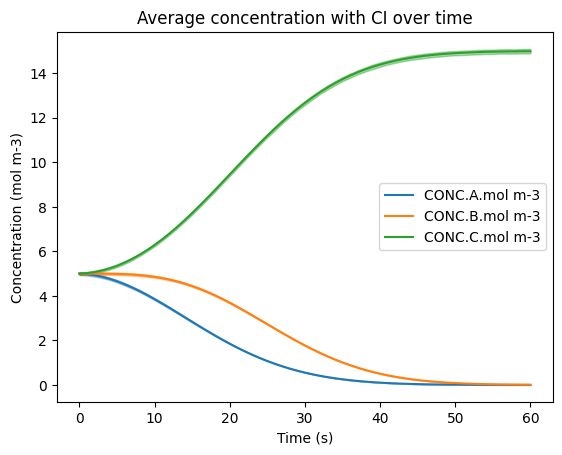

In [91]:
sns.lineplot(data=df_expanded, x='time.s', y='CONC.A.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.A.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.B.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.B.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.C.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.C.mol m-3')
plt.title('Average concentration with CI over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='center right')
plt.show()

## 7. Scaling Tests on NCAR's Casper HPC System

As a reference, the following visualizations use the dask_scaling_tests.csv located in this tutorials folder. These results summarize the scaling tests done on 10,000 and 100,000 grid cell calculations on NCAR's Casper HPC system with 1-4 workers and batch sizes of 1-1,000 each.

Starting with the 10,000 grid cell system. It was found that the greates improvement in performance occurs with the use of at least 2 workers and at least some form of batching. Performance improvements tapered at about 4 workes and batch sizes beyond 100 grid cells per batch. It should be noted that, locally, this simulation takes on average 5 seconds to run. So it is not until the use of at least 3 workers with batching that we regain this performance. The initial slowdown reflects Dask’s overhead, and we emphasize that parallelization should not replace efficient local runs when possible. We use this information to guide the higher expense 100,000 grid cell tests that follow.

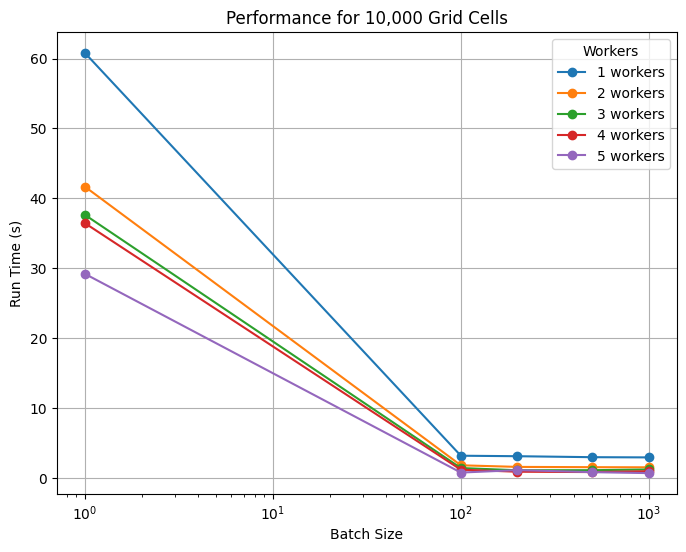

In [39]:
# Load the CSV (replace 'your_file.csv' with your actual filename)
scaling_df = pd.read_csv('dask_scaling_tests.csv')

# Filter for grid_cells == 10000
df_10k = scaling_df[scaling_df['grid_cells'] == 10000]

# Plot: batch_size on x, run_time (s) on y, grouped by workers
plt.figure(figsize=(8,6))

for workers, group in df_10k.groupby('workers'):
    plt.plot(group['batch_size'], group['run_time (s)'], marker='o', label=f'{workers} workers')

plt.xlabel('Batch Size')
plt.ylabel('Run Time (s)')
plt.title('Performance for 10,000 Grid Cells')
plt.legend(title='Workers')
plt.grid(True)
plt.xscale('log')  # Batch size varies a lot, log scale helps visualize
plt.show()

Based on the 10,000 grid cell tests, we skipped individual runs and started directly with batching (100 cells per batch) for the 100,000 grid cell system. Again, the biggest gains came from using at least 2 workers, with improvements tapering beyond ~4 workers. Batch sizes between 100–500 cells were similarly efficient. Locally, this calculation takes on average 1 minute to run, so the use of Dask provides ~85% improvement in run time. We expect even greater benefits at larger scales, and users can apply these scaling results to optimize resource use on their own systems.

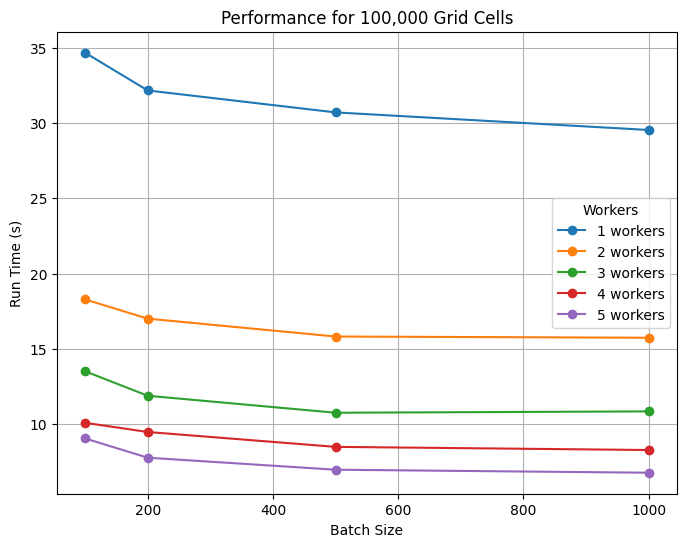

In [29]:
# Filter for grid_cells == 10000
df_100k = scaling_df[scaling_df['grid_cells'] == 100000]

# Plot: batch_size on x, run_time (s) on y, grouped by workers
plt.figure(figsize=(8,6))

for workers, group in df_100k.groupby('workers'):
    plt.plot(group['batch_size'], group['run_time (s)'], marker='o', label=f'{workers} workers')

plt.xlabel('Batch Size')
plt.ylabel('Run Time (s)')
plt.title('Performance for 100,000 Grid Cells')
plt.legend(title='Workers')
plt.grid(True)
#plt.xscale('log')  # Batch size varies a lot, log scale helps visualize
plt.show()